In [24]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy import signal
from scipy.signal import argrelextrema
import numpy as np

# general settings
sampling_rate = 20 # in ms

files = [
    'p1_ed sheeran-shape of you.csv', 
    'p2_ed sheeran-shape of you.csv',
    'p3_ed sheeran-shape of you.csv',
#     'p4_ed sheeran-shape of you.csv',
    'p5_shape of you.csv',
    'p6_shape of you.csv',
    'p7_shape of you.csv',
    'p8_shape of you.csv',
    'p9_shape of you.csv',
    'p10_shape of you.csv',
    'p1_no music.csv',
    'p2_no music.csv',
    'p3_no music.csv',
#     'p4_no music.csv',
    'p5_NotDancing.csv',
    'p6_NotDancing.csv',
    'p7_NotDancing.csv',
    'p8_NotDancing.csv',
    'p7_NotDancing.csv',
    'p10_NotDancing.csv',
    'p1_AVEC-runaway.csv',
    'p2_Daniel Avery-Drone Logic.csv',
    'p3_Against All Logic-Know you.csv',
#     'p4_Chico Rose-Sad.csv',
    'p5_Nea - Some Say.csv',
    'p6_Ruby - Kaiser Chiefs.csv',
    'p7_Ruby - Kaiser Chiefs.csv',
    'p8_Lipps Inc - Funkytown.csv',
    'p9_Lipps Inc - Funkytown.csv',
    'p10_Sweet Lilly - Von wegen Lisbeth.csv',
        ]
sensors = ['Linear_Acceleration', 'Rotation_Vector']
axes = ['x', 'y', 'z']
axis_combinations = [sensor + '.' + axis for sensor in sensors for axis in axes]

# setup df: read from a file and add custom time series
def df_from_filename(filename: str, sampling_rate: int):
    df = pd.read_csv('../data/' + filename, skiprows=3)
    if 'timestamp' in df.columns:
        df = df.drop(columns='timestamp')
        
    def rename(col_name):
        name = col_name
        if 'inear_' in col_name:
            name = 'Linear_Acceleration.'
        elif 'otation_' in col_name:
            name = 'Rotation_Vector.'
        else:
            return str.lower(col_name)
        
        return name + col_name[-1]
        
    df = df.rename(rename, axis='columns')
    
    df['time'] = df.reset_index().index * sampling_rate
    df.fillna(value=0.0)
    return df

def get_metadata(filename: str):
    if 'shape of you' in filename:
        return {
            "title": "Ed Sheeran - Shape of You",
            "tempo": 95.977,
            "time_signature": 4,
        }
    elif 'runaway' in filename:
        return {
            "title": "AVEC - runaway",
            "tempo": 121.971,
            "time_signature": 4,
        }
    elif 'Drone Logic' in filename:
        return {
            "title": "Daniel Avery - Drone Logic",
            "tempo": 114.027,
            "time_signature": 4,
        }
    elif 'Against All' in filename:
        return {
            "title": "Against All Logic - Know you",
            "tempo": 107.022,
            "time_signature": 4,
        }
    elif 'Rose' in filename:
        return {
            "title": "Chico Rose - Sad",
            "tempo": 125.064,
            "time_signature": 4,
        }
    elif 'Some Say' in filename:
        return {
            "title": "Nea - Some Say",
            "tempo": 104.993,
            "time_signature": 4,
        }
    elif 'Kaiser Chiefs' in filename:
        return {
            "title": "Kaiser Chiefs - Ruby",
            "tempo": 93.416,
            "time_signature": 4,
        }
    elif 'Funkytown' in filename:
        return {
            "title": "Lipps Inc. - Funkytown",
            "tempo": 104.993,
            "time_signature": 4,
        }
    elif 'Sweet Lilly' in filename:
        return {
            "title": "Von wegen Lisbeth - Sweet Lilly",
            "tempo": 141.08,
            "time_signature": 4,
        }
    else:
        return {
            "title": "other",
            "tempo": 96,
            "time_signature": 4
        }

def get_song_data(filename: str):
    metadata = get_metadata(filename)
    person = filename.rsplit('_', 1)[0].replace('p','')
    return {
        'person': person,
        'title': metadata['title'],
        'time_signature': metadata['time_signature'],
        'bpm': metadata['tempo'],
        'time_between_beats': 60 / metadata['tempo'],
        'time_between_peaks': 60 / metadata['tempo'] * metadata['time_signature']
    }

# we need to skip start and end of the traces, since that would probably contain some failed data
def cut_df(df: pd.DataFrame):
    # first we wait 3 seconds and then use 10 seconds of the trace
    start = int(3 * 1000)
    end = int(13 * 1000)
    return df.loc[(df['time'] >= start) & (df['time'] <= end)]

def peaks_in_df(df: pd.DataFrame, sampling_rate: int, song_data, comp = np.greater):
    samples_per_second = 1000 / sampling_rate
    samples_per_beat = samples_per_second * song_data['time_between_beats']
    window_size = int(samples_per_beat / 2)
    extrema_indices = [argrelextrema(df[axis].values, comparator=comp, order=window_size)[0] for axis in axis_combinations]
    return [df['time'].values[indices] for indices in extrema_indices]

def calculate_peak_diffs(peaks: [int]):
    return np.diff(peaks, n=1)

def analyze_peak_diffs(peaks_diffs: [int]):
    # clean the diff array (using IQR algorithm)
    q1 = np.quantile(peaks_diffs, .25)
    q3 = np.quantile(peaks_diffs, .75)
    iqr = q3 - q1
    cleaned_diffs = peaks_diffs[(peaks_diffs > q1 - 1.5*iqr) & (peaks_diffs < q3 + 1.5*iqr)]
    percentage_cleaned = 1 - cleaned_diffs.size / peaks_diffs.size

    # calculate estimated bpm
    mean_diffs = np.mean(cleaned_diffs)
    bpm = 60 * 1000 / mean_diffs

    # calculate confidence of estimation (the nearer to 0 the better)
    # = coefficient of variation
    cov = np.std(cleaned_diffs) / mean_diffs

    return bpm, cov, percentage_cleaned

def filter_bad_results(analysis_results: [(float, float, float)]):
    indexed_results = [(i, analysis_results[i]) for i in range(0, len(analysis_results))]
    return list(filter(lambda i: i[0] < 3, indexed_results))

#     # filter out too inconfident and series with too much replaced values
#     cov_threshold = .45
#     cleanup_threshold = .3
#     filtered_results = list(filter(lambda i: (i[1][1] < cov_threshold) & (i[1][2] < cleanup_threshold), indexed_results))
#     return filtered_results

def calculate_result(filtered_results: (int, (float, float, float))):
    sums = [0,0,0]
    for i, (bpm, cov, cleaned) in filtered_results:
        sums[0] += bpm
        sums[1] += cov
        sums[2] += cleaned

    for i in range(0,3):
        sums[i] /= len(filtered_results)

    return sums[0], sums[1], sums[2]

# read all dataframes for given files
dfs = [df_from_filename(f, sampling_rate) for f in files]
# get song metadata for all files
song_data = [get_song_data(f) for f in files]

# cut off start and end of dfs (putting phone in pocket...)
cut_dfs = [cut_df(df) for df in dfs]


# find peaks (for all axes)
peaks_per_df = [peaks_in_df(cut_dfs[i], sampling_rate, song_data[i]) for i in range(0, len(dfs))]
# calculate time between all peaks (for all axes)
peak_diffs_per_df = [[calculate_peak_diffs(peak) for peak in series_peaks] for series_peaks in peaks_per_df]
# calculate bpm (for all axes)

axis_results_per_df = [[analyze_peak_diffs(diffs) for diffs in series_peak_diffs] for series_peak_diffs in peak_diffs_per_df]
# filter out axis results that are unusable (e.g. too much normalized away, or too big variance) (for all files)

filtered_results = [filter_bad_results(axis_results) for axis_results in axis_results_per_df]
# calculate results (for all files)
results = [calculate_result(fr) for fr in filtered_results]

category_width = int(len(files)/3)

print("Shape of You")
for i in range(0,category_width):
    print('{0} -> {1}, {2}'.format(results[i],results[i][1] < .3,100 * results[i][0] / song_data[i]['bpm']))
    
print("not dancing")
for i in range(category_width,2*category_width):
    print('{0} -> {1}, {2}'.format(results[i],results[i][1] < .3,100 * results[i][0] / song_data[i]['bpm']))

print("other music")
for i in range(2*category_width,3*category_width):
    print('{0} -> {1}, {2}\t{3}({4})'.format( results[i],results[i][1] < .3,100 * results[i][0] / song_data[i]['bpm'],song_data[i]['title'],song_data[i]['bpm']))

Shape of You
(100.57441727687554, 0.2849063165698152, 0.06869658119658117) -> True, 104.79012396394505
(109.52629454503517, 0.24247894107750878, 0.06060606060606059) -> True, 114.11723073760918
(105.81178368281009, 0.2730815679659151, 0.019607843137254905) -> True, 110.24702135179271
(98.91509463154951, 0.2829862461673076, 0.0434173669467787) -> True, 103.06124866535681
(93.33840856148834, 0.275849793737264, 0.023809523809523798) -> True, 97.25080859110864
(89.36074009414808, 0.33476835384493975, 0.022222222222222216) -> False, 93.10641100904182
(91.2824297904943, 0.22009649122758201, 0.11904761904761903) -> True, 95.10865081268877
(96.40367572464875, 0.1830421796900655, 0.14493284493284495) -> True, 100.44456038910234
(91.47216754348294, 0.33060989374660527, 0.0) -> False, 95.30634166881954
not dancing
(92.95091947291836, 0.2755029331779009, 0.047619047619047596) -> True, 96.82387445095662
(118.40480813406892, 0.2751320389379634, 0.07037037037037037) -> True, 123.3383418063218
(92.061

In [25]:
print("Shape of you")
for i in range(0, len(cut_dfs)):
    if i == 9:
        print("\nnot dancing")
    if i == 18:
        print("\nEnergetic dancing")
    print(np.std(cut_dfs[i][axis_combinations[0]].values))


print('\nAverages:')
print(np.mean([np.std(cut_dfs[i][axis_combinations[0]].values) for i in range(0, 9)]))
print(np.mean([np.std(cut_dfs[i][axis_combinations[0]].values) for i in range(9, 18)]))
print(np.mean([np.std(cut_dfs[i][axis_combinations[0]].values) for i in range(18, 27)]))

Shape of you
1.7936325614280308
2.672890112352104
6.086907841362444
2.480314051271342
3.6429465809966515
4.821236876108525
14.132129720174072
2.4792634613360445
1.2741011870897925

not dancing
0.8511362950355825
0.49976799483336926
0.3667052654197839
1.3626178387398022
1.3609030741946422
1.2278067894757068
0.05114410120172379
1.2278067894757068
0.40575096610891936

Energetic dancing
4.730274764024104
2.8368978451161886
5.972042294281417
5.929128634203568
2.9059733001134362
4.891398311082575
13.301379382373376
11.421594406726376
0.5985764324774323

Averages:
4.375935821346556
0.8170710127205819
5.843029485599831


In [26]:
def visualize_all_axes(df_id):
    df = cut_dfs[df_id]
    for sensor in ('Linear_Acceleration', 'Rotation_Vector'):
        fig = go.Figure()
        for axis in ('%s.x', '%s.y', '%s.z'):
            fig.add_trace(go.Scatter(
            y = df[axis % sensor],
            x = df['time'],
            mode = 'lines',
            name=axis % sensor
        ))
        fig.update_layout(title=sensor)
        fig.show()

visualize_all_axes(0)

In [27]:
def plot_series_with_beats(df_id, axis_id, first_peak: int = -1):
    df = cut_dfs[df_id]
    sd = song_data[df_id]
    axis = axis_combinations[axis_id]
    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = df[axis],
        x = df['time']/1000,
        mode = 'lines',
        name=axis
    ))

    ymin = df[axis].min()
    ymax = df[axis].max()

    # generate beat definitions
    shapes = []
    count = 0
    i = df['time'].min()

    if first_peak != -1:
        peak = peaks_per_df[df_id][axis_id][first_peak]
        i = peak

    while i < df['time'].max():
        count += 1
        i += int(sd['time_between_beats'] * 1000)
        shapes.append(dict(type= 'line', xref= 'x', x0 =i/1000.0, x1 = i/1000.0, y0= ymin, y1= ymax))
        if count % sd['time_signature'] == 0:
            shapes[-1]['line'] = dict(color="Red")
            # we color every fourth beat red to show how long a bar is (maybe misleading since this
            # is not necessarily the start or end of a bar


    fig.update_layout(title=axis, shapes = shapes)
    fig.show()

plot_series_with_beats(0, 1, 0)


In [28]:
def visualize_peaks(df_id: int, axis_id: int, printme: bool = False, add_lower_peaks = False):
    peaks = peaks_per_df[df_id][axis_id]
    df = cut_dfs[df_id]
    axis = axis_combinations[axis_id]


    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = df[axis],
        x = df['time']/1000,
        mode = 'lines',
        name=axis
    ))

    fig.add_trace(go.Scatter(
        x=[j/1000 for j in peaks],
        y=[float(df.loc[df['time'] == j][axis]) for j in peaks],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='cross'
        ),
        name='Detected Peaks'
    ))


    fig.update_layout(
        yaxis_title='linear acceleration [m/s²]',
        xaxis_title='time [s]',
    )

    if add_lower_peaks:
        lower_peaks = peaks_in_df(df, sampling_rate, song_data[df_id], comp = np.less)[axis_id]
        fig.add_trace(go.Scatter(
            x=[j/1000 for j in lower_peaks],
            y=[float(df.loc[df['time'] == j][axis]) for j in lower_peaks],
            mode='markers',
            marker=dict(
                size=8,
                color='black',
                symbol='cross'
            ),
            name='Detected Peaks'
        ))


    fig.show()
    
visualize_peaks(0, 1, add_lower_peaks=True)


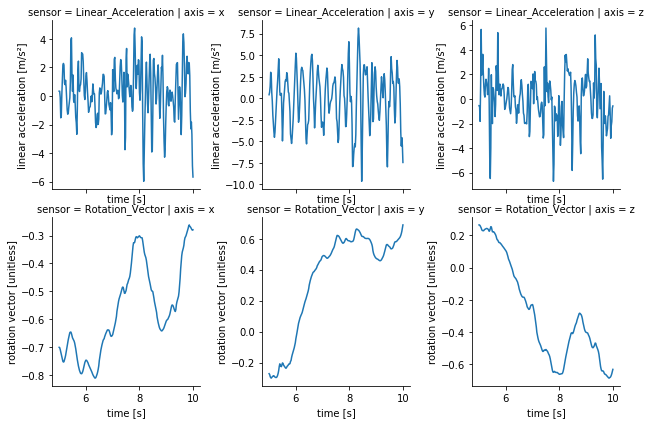

In [29]:
def visualize_all_sensors_facetgrid(df_id: int, start = 5, end = 10):
    s = start * 1000
    e = end * 1000
    df = cut_dfs[df_id]

    # some more plots...
    melted_dance = pd.melt(df[(df.time >= s) & (df.time <= e)], id_vars=['time'], value_vars=axis_combinations)
   
    def split_sensor_to_sensor_and_axis(col: str):
        l= col.split(sep = '.')
        return l[0], l[1]
    
    melted_dance['sensor'], melted_dance['axis'] = zip(*melted_dance['variable'].apply(split_sensor_to_sensor_and_axis))
    melted_dance['time'] = melted_dance['time'].divide(1000)
    g = sns.FacetGrid(data = melted_dance, row = 'sensor', col = 'axis', sharey=False)
    g = g.map(plt.plot, 'time', 'value')

    g.axes[0,0].set_xlabel('time [s]')
    g.axes[0,1].set_xlabel('time [s]')
    g.axes[0,2].set_xlabel('time [s]')
    g.axes[1,0].set_xlabel('time [s]')
    g.axes[1,1].set_xlabel('time [s]')
    g.axes[1,2].set_xlabel('time [s]')
    g.axes[0,0].set_ylabel('linear acceleration [m/s²]')
    g.axes[0,1].set_ylabel('linear acceleration [m/s²]')
    g.axes[0,2].set_ylabel('linear acceleration [m/s²]')
    g.axes[1,0].set_ylabel('rotation vector [unitless]')
    g.axes[1,1].set_ylabel('rotation vector [unitless]')
    g.axes[1,2].set_ylabel('rotation vector [unitless]')


    plt.savefig('facetgrid.png')
    plt.show()
    
visualize_all_sensors_facetgrid(0)